In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import zipfile

with zipfile.ZipFile('/content/drive/MyDrive/Datasets/Emotion.zip', 'r') as zip_ref:
    zip_ref.extractall('.')

In [ ]:
import os
from skimage import io

PATH = 'Emotion'

classes = os.listdir(PATH)
classes

['Happy', 'Angry', 'Sad', 'Fear', 'Neutral', 'Suprise']

In [ ]:
imgs, labels = [], []

for i, lab in enumerate(classes):
  paths = os.listdir(f'{PATH}/{lab}')
  print(f'Categoría: {lab}. Imágenes: {len(paths)}')
  paths = [p for p in paths if p[-3:] == "jpg"]
  imgs += [f'{PATH}/{lab}/{img}' for img in paths]
  labels += [i]*len(paths)

print(len(imgs))

Categoría: Happy. Imágenes: 7215
Categoría: Angry. Imágenes: 3995
Categoría: Sad. Imágenes: 4830
Categoría: Fear. Imágenes: 4097
Categoría: Neutral. Imágenes: 4965
Categoría: Suprise. Imágenes: 3171
28273


In [ ]:
from sklearn.model_selection import train_test_split

train_imgs, test_imgs, train_labels, test_labels = train_test_split(imgs, labels, test_size=0.2, stratify=labels)

len(train_imgs), len(test_imgs)

(22618, 5655)

In [ ]:
import torch
import albumentations as A
from skimage import io
import os

device = "cuda" if torch.cuda.is_available() else "cpu"

class Dataset(torch.utils.data.Dataset):
  def __init__(self, X, y, trans, device):
    self.X = X
    self.y = y
    self.trans = trans
    self.device = device

  def __len__(self):
    return len(self.X)

  def __getitem__(self, ix):
    path = self.X[ix]
    if os.path.exists(self.X[ix]) and os.path.isfile(self.X[ix]):
      img = io.imread(self.X[ix])
    else:
      img = io.imread(self.X[ix-1])

    # Asegúrate de que la imagen tenga un solo canal (escala de grises)
    if len(img.shape) != 2:
      img = io.imread(self.X[ix-1])

    if self.trans:
      img = self.trans(image=img)["image"]

    x = torch.from_numpy(img / 255.).float()
    x = x * 2. - 1.
    x = x.unsqueeze(0)  # Agrega una dimensión para el canal (1 canal en escala de grises)

    y = torch.tensor(self.y[ix])
    return x, y

trans = A.Compose([
    A.Resize(48, 48)
])

train = Dataset(train_imgs, train_labels, trans, device)
len(train)


22618

In [ ]:
img, label = train[0]
img.shape, img.dtype, img.max(), img.min()

(torch.Size([1, 48, 48]), torch.float32, tensor(1.), tensor(-0.8980))

In [ ]:
dataloader = torch.utils.data.DataLoader(train, batch_size=128, shuffle=True)

imgs, labels = next(iter(dataloader))
imgs.shape, labels.shape

(torch.Size([128, 1, 48, 48]), torch.Size([128]))

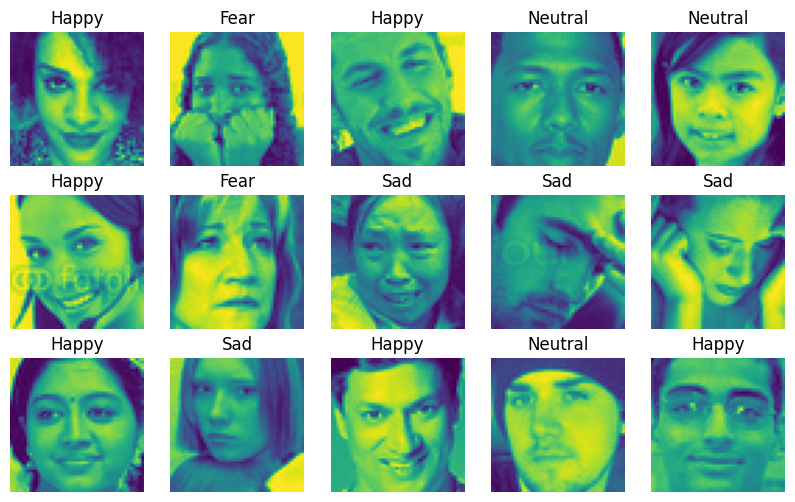

In [ ]:
import random
import matplotlib.pyplot as plt

fig, axs = plt.subplots(3,5, figsize=(10,6))
for _ax in axs:
  for ax in _ax:
    ix = random.randint(0, len(train)-1)
    img, lab = train[ix]
    img = (img+1)/2
    ax.imshow(img.permute(1,2,0).cpu())
    ax.axis('off')
    ax.set_title(classes[lab])
plt.show()

In [ ]:
import torch.nn as nn
import torch

class Generator(nn.Module):
    def __init__(self, z_dims, channels, features_g):
        super(Generator, self).__init__()
        self.gen = nn.Sequential(
            self._block(z_dims, features_g * 16, stride=1, padding=0),
            self._block(features_g * 16, features_g * 8),
            self._block(features_g * 8, features_g * 4),
            self._block(features_g * 4, features_g * 2, kernel=6),
            nn.ConvTranspose2d(features_g * 2, channels, kernel_size=4, stride=2, padding=1),
            nn.Tanh()
        )

    def _block(self, in_c, out_c, kernel=4, stride=2, padding=1):
        return nn.Sequential(
            nn.ConvTranspose2d(
                in_c,
                out_c,
                kernel,
                stride,
                padding,
                bias=False
            ),
            nn.BatchNorm2d(out_c),
            nn.ReLU()
        )

    def forward(self, x):
        return self.gen(x)

In [ ]:
# Crear una instancia del generador para imágenes en escala de grises
generator = Generator(100, 1, 64)  # Usar 1 canal para escala de grises

# Generar una imagen de escala de grises
output = generator(torch.randn(100, 100, 1, 1))  # Usar 1 canal para el espacio latente
output.shape

torch.Size([100, 1, 68, 68])

In [ ]:
class Discriminator(nn.Module):
  def __init__(self, channels, features_d):
      super(Discriminator, self).__init__()
      self.disc = nn.Sequential( #64*64
          nn.Conv2d(channels, features_d, kernel_size=4, stride=2, padding=1), #32*32
          nn.LeakyReLU(0.2),
          self._block(features_d, features_d*2), #16*16
          self._block(features_d*2, features_d*4), #8*8
          self._block(features_d*4, features_d*8), #4*4
          nn.Conv2d(features_d*8, 1, kernel_size=4, stride=2, padding=1), #1*1
          nn.Sigmoid()
      )

  def _block(self, in_c, out_c, kernel=4, stride=2, padding=1):
    return nn.Sequential(
        nn.Conv2d(in_c, out_c, kernel, stride, padding, bias=False),
        nn.BatchNorm2d(out_c),
        nn.LeakyReLU(0.2)
    )

  def forward(self, x):
    return self.disc(x)

In [ ]:
# Crear una instancia del discriminador para imágenes en escala de grises
discriminator = Discriminator(1, 64)  # Usar 1 canal para imágenes en escala de grises

# Generar una salida del discriminador
output = discriminator(torch.randn(100, 1, 64, 64))  # Usar 1 canal para las imágenes de entrada
output.shape

torch.Size([100, 1, 2, 2])

In [ ]:
def initialize_weights(model):
  for m in model.modules():
    if isinstance(m, (nn.Conv2d, nn.ConvTranspose2d, nn.BatchNorm2d)):
      nn.init.normal_(m.weight.data, 0.0, 0.002)

In [ ]:
LR = 2e-4
CHANNELS = 1
Z_DIM = 100
EPOCHS = 30
F_D = 64
F_G = 64

In [ ]:
from fastprogress import master_bar, progress_bar
import numpy as np

def fit(gen, disc, dataloader):
  disc.to(device)
  gen.to(device)
  g_optimizer = torch.optim.Adam(gen.parameters(), lr=LR, betas=(0.5, 0.999))
  d_optimizer = torch.optim.Adam(disc.parameters(), lr=LR, betas=(0.5, 0.999))
  criterion = nn.BCELoss()
  gen.train()
  disc.train()
  g_loss, d_loss = [], []
  mb = master_bar(range(1, EPOCHS+1))
  hist = {'g_loss': [], 'd_loss': []}
  for epoch in mb:
    for real, y in progress_bar(dataloader, parent=mb):
      real = real.to(device)
      noise = torch.randn((128, Z_DIM, 1,1)).to(device)
      fake = gen(noise)

      disc_real = disc(real).reshape(-1)
      loss_disc_real = criterion(disc_real, torch.ones_like(disc_real))
      disc_fake = disc(fake).reshape(-1)
      loss_disc_fake = criterion(disc_fake, torch.zeros_like(disc_fake))
      loss_disc = (loss_disc_real + loss_disc_fake)/2
      disc.zero_grad()
      loss_disc.backward(retain_graph=True)
      d_optimizer.step()
      d_loss.append(loss_disc.item())

      output = disc(fake).reshape(-1)
      loss_gen = criterion(output, torch.ones_like(output))
      gen.zero_grad()
      loss_gen.backward()
      g_optimizer.step()
      g_loss.append(loss_gen.item())

      mb.child.comment = f'g_loss {np.mean(g_loss):.5f} d_loss {np.mean(d_loss):.5f}'
    mb.write(f'Epoch {epoch}/{EPOCHS} g_loss {np.mean(g_loss):.5f} d_loss {np.mean(d_loss):.5f}')
    hist['g_loss'].append(np.mean(g_loss))
    hist['d_loss'].append(np.mean(d_loss))
    torch.save(gen.state_dict(),  f"./checkpoint_g.pt")
    torch.save(disc.state_dict(),  f"./checkpoint_d.pt")
    print(f"Model saved at epoch {epoch} with g_loss {np.mean(g_loss):.5f}")
  return hist

In [ ]:
gen = Generator(Z_DIM, CHANNELS, 64)
disc = Discriminator(CHANNELS, 64)
initialize_weights(gen)
initialize_weights(disc)

In [ ]:
hist = fit(gen, disc, dataloader)

Model saved at epoch 1 with g_loss 2.05240
Model saved at epoch 2 with g_loss 3.30535
Model saved at epoch 3 with g_loss 4.09968
Model saved at epoch 4 with g_loss 4.67224
Model saved at epoch 5 with g_loss 5.11876
Model saved at epoch 6 with g_loss 5.48475
Model saved at epoch 7 with g_loss 5.79515
Model saved at epoch 8 with g_loss 6.06498
Model saved at epoch 9 with g_loss 6.30399
Model saved at epoch 10 with g_loss 6.51891
Model saved at epoch 11 with g_loss 6.71441
Model saved at epoch 12 with g_loss 6.89401
Model saved at epoch 13 with g_loss 7.06038
Model saved at epoch 14 with g_loss 7.21555
Model saved at epoch 15 with g_loss 7.36112
Model saved at epoch 16 with g_loss 7.49845
Model saved at epoch 17 with g_loss 7.62857
Model saved at epoch 18 with g_loss 7.75235
Model saved at epoch 19 with g_loss 7.87051
Model saved at epoch 20 with g_loss 7.98369
Model saved at epoch 21 with g_loss 8.09240
Model saved at epoch 22 with g_loss 8.19709
Model saved at epoch 23 with g_loss 8.298

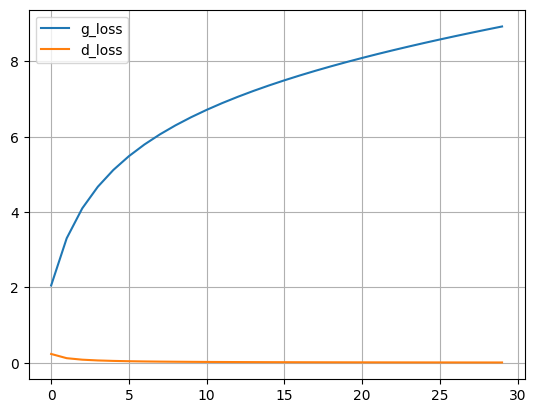

In [ ]:
#Modelo para imagenes de 64x64
import pandas as pd

df = pd.DataFrame(hist)
df.plot(grid=True)
plt.show()

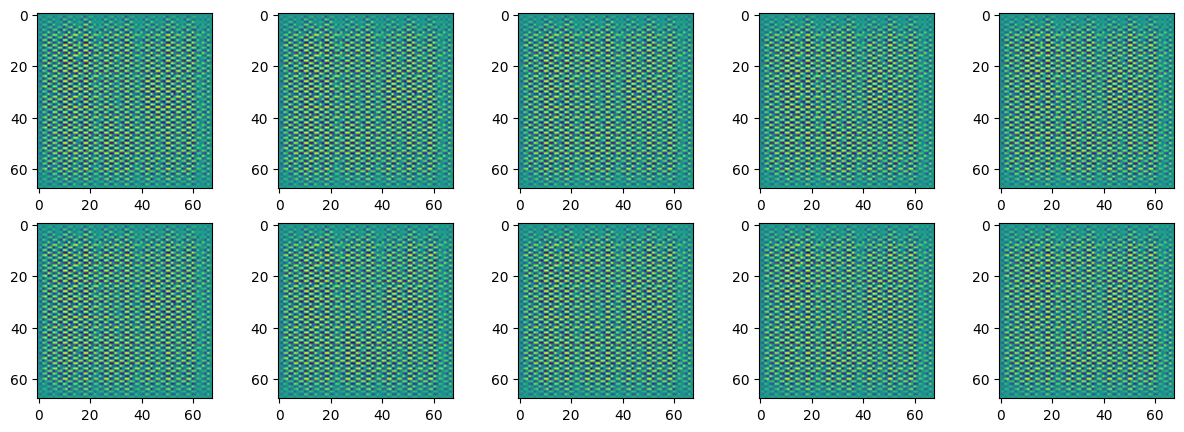

In [ ]:
gen.eval()
with torch.no_grad():
  noise = torch.randn((10, 100, 1, 1)).to(device)
  generated_images = gen(noise)
  fig, axs = plt.subplots(2,5,figsize=(15,5))
  i = 0
  for ax in axs:
    for _ax in ax:
      img = generated_images[i].permute(1,2,0).cpu()
      img = (img+1.)/2.
      _ax.imshow(img)
      i+=1
  plt.show()